# Handwritten Digit Recognition - using MNIST dataset


### 1. Import Packages

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# moves model to train on gpu
device = ("cuda" if torch.cuda.is_available() else "cpu")

### 2. Prepare The Dataset

In [14]:
# normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])



# Download and load the training data
train_set = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [15]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
# Check the datatype 
print(type(images)) 
# size of the image
print(images.shape) 
# size of the labels
print(labels.shape) 

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


### 3. Explore the MNIST hand written digits

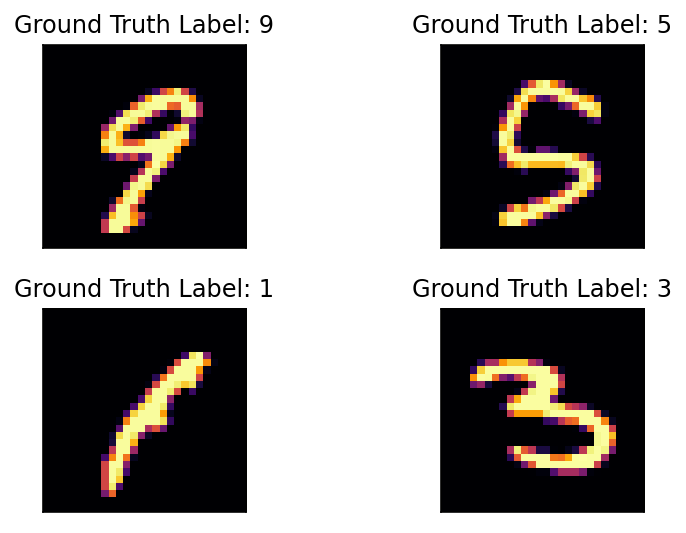

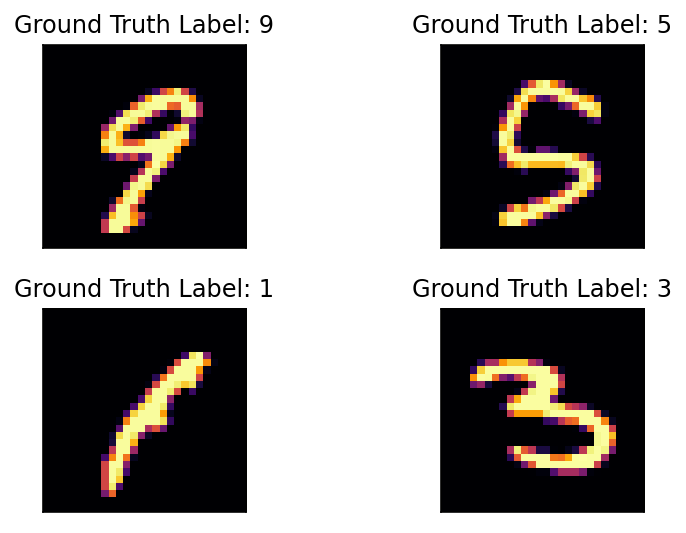

In [16]:
fig = plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='inferno')
    plt.title("Ground Truth Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])
fig

### 4. Training of Convolutional Neural Network

In [17]:
class SimpleNetwork(nn.Module):

    def __init__(self):
        super(SimpleNetwork, self).__init__()
        # Convolutional Neural Network Layer 
        self.convolutaional_neural_network_layers = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1), 
                nn.ReLU(), nn.MaxPool2d(kernel_size=2), 
                # output of our second conv layer
                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
                nn.ReLU(), nn.MaxPool2d(kernel_size=2)
        )

        # Linear layer
        self.linear_layers = nn.Sequential(
                nn.Linear(in_features=24*7*7, out_features=64),          
                nn.ReLU(),
                nn.Dropout(p=0.2), # Dropout
                nn.Linear(in_features=64, out_features=10)
        )

    # Defining the forward pass 
    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        # flatten it or rearrange the output into a vector
        x = x.view(x.size(0), -1)
        # pass it through the linear layer
        x = self.linear_layers(x)
        x = F.log_softmax(x, dim=1)
        return x

In [18]:
model = SimpleNetwork()
model.to(device)
print(model)

SimpleNetwork(
  (convolutaional_neural_network_layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [19]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [20]:
epochs = 10 # total number of iterations

train_losses = []
test_losses = []

for epoch in range(epochs):
    # prepare model for training
    model.train()
    train_loss = 0

    for idx, (images, labels) in enumerate(trainloader): 

        # Send these >>> To GPU
        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        # Forward pass
        output = model(images)
        loss = criterion(output, labels)

        #Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    else:
        # prep model for evaluation
        model.eval() 
        test_loss = 0
        accuracy = 0

        with torch.no_grad():
            for images, labels in testloader:
                
                images = images.to(device)
                labels = labels.to(device)
                
                log_probabilities = model(images)
                test_loss += criterion(log_probabilities, labels)

                probabilities = torch.exp(log_probabilities)
                top_prob, top_class = probabilities.topk(1, dim=1)
                predictions = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(predictions.type(torch.FloatTensor))
        
        train_losses.append(train_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}  ".format(epoch+1, epochs),
              "Training loss: {:.4f}  ".format(train_loss/len(trainloader)),
              "Testing loss: {:.4f}  ".format(test_loss/len(testloader)),
              "Test accuracy: {:.4f}  ".format(accuracy/len(testloader)))

Epoch: 1/10   Training loss: 0.7327   Testing loss: 0.2292   Test accuracy: 0.9300  
Epoch: 2/10   Training loss: 0.2326   Testing loss: 0.1556   Test accuracy: 0.9513  
Epoch: 3/10   Training loss: 0.1681   Testing loss: 0.1072   Test accuracy: 0.9668  
Epoch: 4/10   Training loss: 0.1339   Testing loss: 0.0855   Test accuracy: 0.9731  
Epoch: 5/10   Training loss: 0.1153   Testing loss: 0.0815   Test accuracy: 0.9737  
Epoch: 6/10   Training loss: 0.0996   Testing loss: 0.0759   Test accuracy: 0.9768  
Epoch: 7/10   Training loss: 0.0903   Testing loss: 0.0600   Test accuracy: 0.9809  
Epoch: 8/10   Training loss: 0.0823   Testing loss: 0.0664   Test accuracy: 0.9773  
Epoch: 9/10   Training loss: 0.0776   Testing loss: 0.0538   Test accuracy: 0.9815  
Epoch: 10/10   Training loss: 0.0705   Testing loss: 0.0460   Test accuracy: 0.9850  


### 5. Model Accuracy Checking - example

In [21]:
def view_classify(img, ps):
    fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
    ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps, color='r' )
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [22]:
img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

with torch.no_grad():
    logits = model.forward(img)
    
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()
print(probabilities)

torch.Size([1, 1, 28, 28])
[6.3694301e-08 2.8884983e-06 1.2501687e-09 1.3125475e-04 1.9604197e-10
 9.9985623e-01 1.5304869e-06 2.7027411e-10 6.0002350e-08 7.9079400e-06]


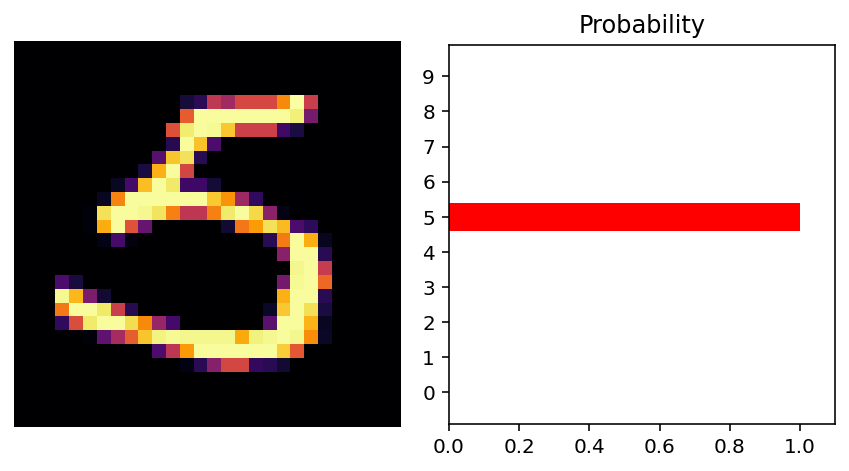

In [23]:
view_classify(img.view(1, 28, 28), probabilities)

### 6. Model Accuracy Estimation

In [24]:
correct_count, all_count = 0, 0
for images,labels in testloader:
    for i in range(len(labels)):
        img = images[i]
        img = img.to(device)
        img = img.view(-1, 1, 28, 28)
        with torch.no_grad():
            logits = model.forward(img)

        ps = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

        probab = list(ps)
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy Estimated =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy Estimated = 0.9849
